# Import Libraries

In [1]:
# Standard Library
import re
import glob
import json
import string
import warnings

# Scientific & Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP - Scikit-learn
from sklearn.feature_extraction.text import (
    TfidfVectorizer, 
    CountVectorizer
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import fetch_20newsgroups

# NLP - NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# NLP - Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import (
    LdaModel, 
    LdaMulticore, 
    CoherenceModel, 
    TfidfModel
)

# NLP - SpaCy & Sentiment
import spacy
from textblob import TextBlob

# Topic Modeling - BERTopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

# Deep Learning - Transformers
import transformers
import accelerate

# GPU computing
import cupy as cp

# LDA Visualization
import pyLDAvis
import pyLDAvis.gensim_models

# Geospatial
import geopandas as gpd

# Utilities
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm.pandas()

# Warning filters
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Anaconda\envs\topicmodeling\lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Anaconda\envs\topicmodeling\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tools

In [2]:
def summarize_categories(df, column):
    count_per_category = df[column].value_counts()
    percentage_per_category = df[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'count': count_per_category,
        'percentage': percentage_per_category
    })
    return summary

# Load Data

In [3]:
sample_df = pd.read_csv('./data.csv')
sample_df.shape

(399046, 18)

## Initial Preprocessing

Clean Column Nemes

In [4]:
# Clean column names
# Remove leading/trailing whitespace, convert to lowercase, replace spaces with underscores, and remove non-word characters
sample_df.columns = (
    sample_df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '_', regex=True)
    .str.replace(r'[^\w]', '', regex=True)
)

# Display DataFrame information
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399046 entries, 0 to 399045
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_received                 399046 non-null  object 
 1   product                       399046 non-null  object 
 2   subproduct                    399045 non-null  object 
 3   issue                         399045 non-null  object 
 4   subissue                      385096 non-null  object 
 5   consumer_complaint_narrative  239524 non-null  object 
 6   company_public_response       226285 non-null  object 
 7   company                       399046 non-null  object 
 8   state                         397871 non-null  object 
 9   zip_code                      399040 non-null  object 
 10  tags                          24390 non-null   object 
 11  consumer_consent_provided     381808 non-null  object 
 12  submitted_via                 399046 non-nul

Convert 'date' Columns to Datetime Format

In [5]:
# Convert date columns to datetime format
date_cols = ['date_received', 'date_sent_to_company']
sample_df[date_cols] = sample_df[date_cols].apply(pd.to_datetime, errors='coerce')

# Extract day, month, and year from date columns
for col in date_cols:
    sample_df[f'{col}_day'] = sample_df[col].dt.day
    sample_df[f'{col}_month'] = sample_df[col].dt.month
    sample_df[f'{col}_year'] = sample_df[col].dt.year

# Calculate the processing day as the difference between date_sent_to_company and date_received
sample_df['processing_day'] = (sample_df['date_sent_to_company'] - sample_df['date_received']).dt.days

# Display the first few rows of the DataFrame after processing dates
sample_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,timely_response,consumer_disputed,complaint_id,date_received_day,date_received_month,date_received_year,date_sent_to_company_day,date_sent_to_company_month,date_sent_to_company_year,processing_day
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,...,Yes,NaN,6384775,1,1,2023,1,1,2023,0
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,...,Yes,NaN,6384724,1,1,2023,1,1,2023,0
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,...,Yes,NaN,6384896,1,1,2023,1,1,2023,0
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,...,Yes,NaN,6382439,1,1,2023,1,1,2023,0
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,...,Yes,NaN,6383627,1,1,2023,1,1,2023,0


# Exploratory Data Analysis (EDA)

| Column                         | Description                                                                 |
|--------------------------------|-----------------------------------------------------------------------------|
| Date received                  | The date when the consumer's complaint was received.                        |
| Product                        | The specific financial product or service related to the complaint.         |
| Sub-product                    | A more detailed sub-category of the product or service.                     |
| Issue                          | The main problem described in the consumer's complaint.                     |
| Sub-issue                      | Additional details or sub-category related to the main issue.               |
| Consumer complaint narrative   | A text description provided by the consumer detailing their complaint.      |
| Company public response        | The response or statement issued by the company regarding the complaint.    |
| Company                        | The name of the company being complained about.                              |
| State                          | The state of residence of the consumer.                                     |
| ZIP code                       | The postal code of the consumer's location.                                 |
| Tags                           | Additional tags or labels related to the complaint.                         |
| Consumer consent provided?     | Indicates whether the consumer consented to publish their complaint.        |
| Submitted via                  | The channel or method used to submit the complaint.                         |
| Date sent to company           | The date when the complaint was forwarded to the company for response.      |
| Company response to consumer   | The response or resolution from the company to the consumer's complaint.    |
| Timely response?               | Indicates whether the company responded in a timely manner.                 |
| Consumer disputed?             | Indicates whether the consumer disputed the company's response.             |
| Complaint ID                   | A unique identifier assigned to each complaint.                             |

**More Detail About Dataset Features :** https://cfpb.github.io/api/ccdb/fields.html

## Dataset Overview

In [6]:
# Display the first few rows of the DataFrame
sample_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,timely_response,consumer_disputed,complaint_id,date_received_day,date_received_month,date_received_year,date_sent_to_company_day,date_sent_to_company_month,date_sent_to_company_year,processing_day
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,...,Yes,NaN,6384775,1,1,2023,1,1,2023,0
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,...,Yes,NaN,6384724,1,1,2023,1,1,2023,0
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,...,Yes,NaN,6384896,1,1,2023,1,1,2023,0
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,...,Yes,NaN,6382439,1,1,2023,1,1,2023,0
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,...,Yes,NaN,6383627,1,1,2023,1,1,2023,0


## Create a Summary DataFrame for Non-null Values

In [7]:
# Create a summary DataFrame for non-null values
non_null_summary = pd.DataFrame({
    'feature': sample_df.columns,
    'total_non_null': sample_df.notnull().sum().values,
    'total_row': sample_df.shape[0],
    'non_null_percentage': (
        sample_df.notnull().sum().values / sample_df.shape[0] * 100
    ).round(2)
})

# Sort the summary DataFrame by non-null percentage in ascending order
non_null_summary = (
    non_null_summary
    .sort_values(by='non_null_percentage', ascending=True)
    .reset_index(drop=True)
)

# Display the non-null summary DataFrame
non_null_summary

,feature,total_non_null,total_row,non_null_percentage
0,consumer_disputed,0,399046,0.00
1,tags,24390,399046,6.11
2,company_public_response,226285,399046,56.71
3,consumer_complaint_narrative,239524,399046,60.02
4,consumer_consent_provided,381808,399046,95.68
5,subissue,385096,399046,96.50
6,state,397871,399046,99.71
7,date_received,399046,399046,100.00
8,date_sent_to_company_month,399046,399046,100.00
9,date_sent_to_company_day,399046,399046,100.00


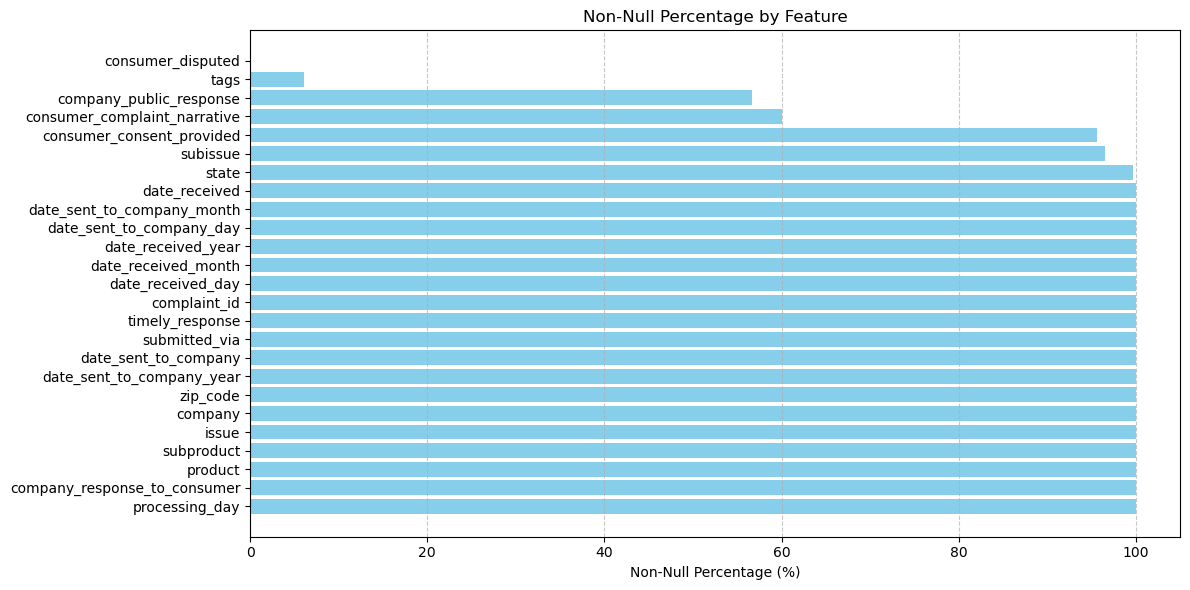

In [8]:
# Plotting the non-null percentage by feature
plt.figure(figsize=(12, 6))
plt.barh(
    non_null_summary['feature'],
    non_null_summary['non_null_percentage'],
    color='skyblue'
)
plt.xlabel('Non-Null Percentage (%)')
plt.title('Non-Null Percentage by Feature')
plt.gca().invert_yaxis()  # Highest missing at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Explore Product Column

In [9]:
# summarize the product categories
summary_product = summarize_categories(sample_df, 'product')
summary_product

,count,percentage
product,,
Credit reporting or other personal consumer reports,247784,62.094094
"Credit reporting, credit repair services, or other personal consumer reports",72712,18.221458
Debt collection,25599,6.415050
Checking or savings account,13762,3.448725
Credit card,10479,2.626013
"Money transfer, virtual currency, or money service",8038,2.014304
Mortgage,5551,1.391068
Credit card or prepaid card,5008,1.254993
Student loan,3333,0.835242


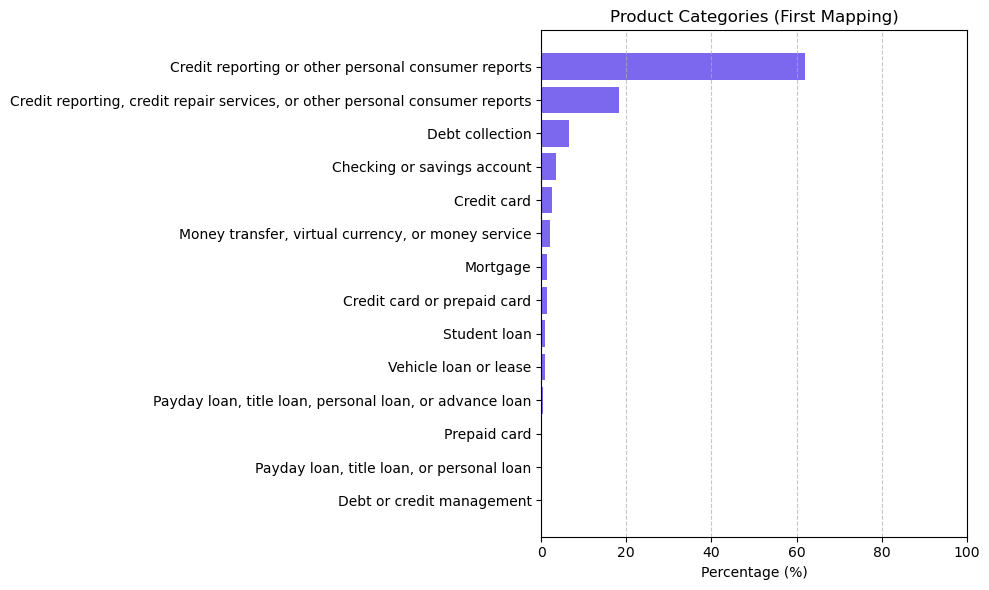

In [10]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_product.index.astype(str),
    summary_product['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insights from Unique Values in the Product Column**

1. **Category normalization is necessary**  
    Many products are essentially the same but phrased differently. Normalizing categories ensures consistency and prevents bias in analysis or modeling.

2. **Combine into _Credit reporting_**  
    - Credit reporting, credit repair services, or other personal consumer reports  
    - Credit reporting or other personal consumer reports  
    _Both refer to credit reporting services and consumer reports._

3. **Combine into _Credit card / Prepaid card_**  
    - Credit card or prepaid card  
    - Credit card  
    - Prepaid card  
    _All relate to credit or prepaid card services; only the card type differs._

4. **Combine into _Payday/Title/Personal loan_**  
    - Payday loan, title loan, or personal loan  
    - Payday loan, title loan, personal loan, or advance loan  
    _Both cover payday, title, personal, and advance loans—essentially the same category._


### First Mapping : Clean the 'product' column by mapping similar products to a common category

In [11]:
# Define a mapping dictionary for product categories
mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
    'Credit reporting or other personal consumer reports': 'Credit reporting',
    'Credit card or prepaid card': 'Credit card / Prepaid card',
    'Credit card': 'Credit card / Prepaid card',
    'Prepaid card': 'Credit card / Prepaid card',
    'Payday loan, title loan, or personal loan': 'Payday/Title/Personal loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Payday/Title/Personal loan'
}

# Replace the 'product' column values using the mapping dictionary
sample_df['product_first_mapping'] = sample_df['product'].replace(mapping)

# Summarize the product categories after the first mapping
summary_first_product_mapping = summarize_categories(sample_df, column='product_first_mapping')

# Display the summary DataFrame after the first mapping
summary_first_product_mapping

,count,percentage
product_first_mapping,,
Credit reporting,320496,80.315553
Debt collection,25599,6.415050
Credit card / Prepaid card,16502,4.135363
Checking or savings account,13762,3.448725
"Money transfer, virtual currency, or money service",8038,2.014304
Mortgage,5551,1.391068
Student loan,3333,0.835242
Vehicle loan or lease,3297,0.826221
Payday/Title/Personal loan,2093,0.524501


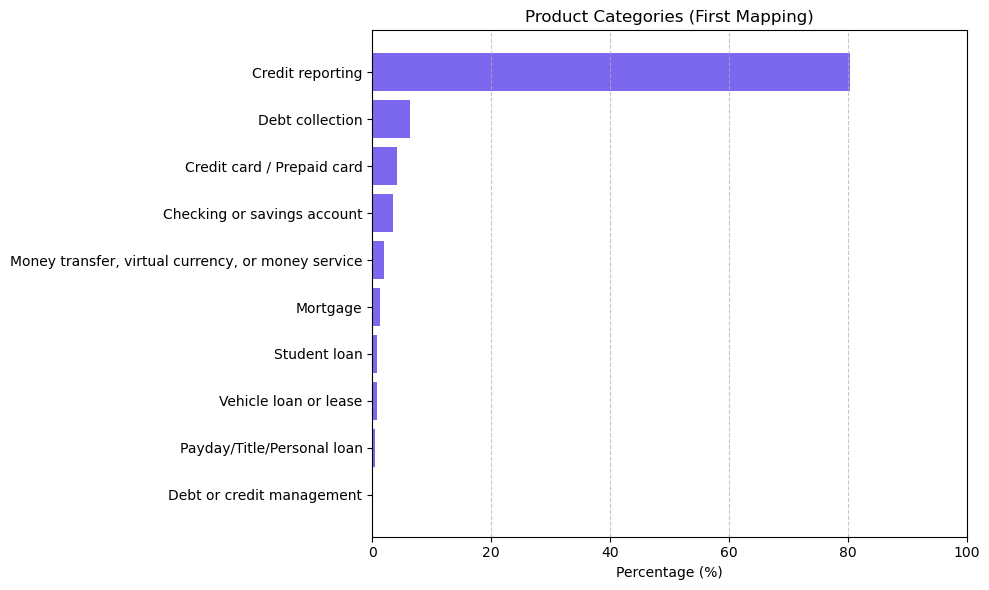

In [12]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_first_product_mapping.index.astype(str),
    summary_first_product_mapping['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insights from Unique Values in the _product first mapping_ Column**

- Categories with less than 1% of total complaints are grouped into broader categories to reduce class imbalance.
- "Debt collection" and "Debt or credit management" are merged into a single "Debt-related" category due to their similar topics.
- "Student loan," "Vehicle loan/lease," and "Payday/Title/Personal loan" are combined into an "Other" category because of their small counts and lack of strong association with major categories.

### Second Mapping : Clean the 'product_first_mapping' column by mapping similar products to a common category

In [13]:
# Define a function to group products into broader categories
def second_product_mapping(product):
    if product == 'Credit reporting':
        return 'Credit reporting'
    elif product == 'Credit card / Prepaid card':
        return 'Credit/Prepaid card'
    elif product in ['Debt collection', 'Debt or credit management']:
        return 'Debt related'
    elif product == 'Checking or savings account':
        return 'Checking/Savings account'
    elif product == 'Money transfer, virtual currency, or money service':
        return 'Money services'
    elif product == 'Mortgage':
        return 'Mortgage'
    else:
        return 'Other'  # Student loan, Vehicle loan/lease, Payday/Title/Personal loan  

# Apply the grouping function to the 'product_first_mapping' column
sample_df['product_second_mapping'] = sample_df['product_first_mapping'].apply(second_product_mapping)

# Summarize the product categories after the second mapping
summary_second_product_mapping = summarize_categories(sample_df, column='product_second_mapping')

# Display the summary DataFrame after the second mapping
summary_second_product_mapping

,count,percentage
product_second_mapping,,
Credit reporting,320496,80.315553
Debt related,25974,6.509024
Credit/Prepaid card,16502,4.135363
Checking/Savings account,13762,3.448725
Other,8723,2.185964
Money services,8038,2.014304
Mortgage,5551,1.391068


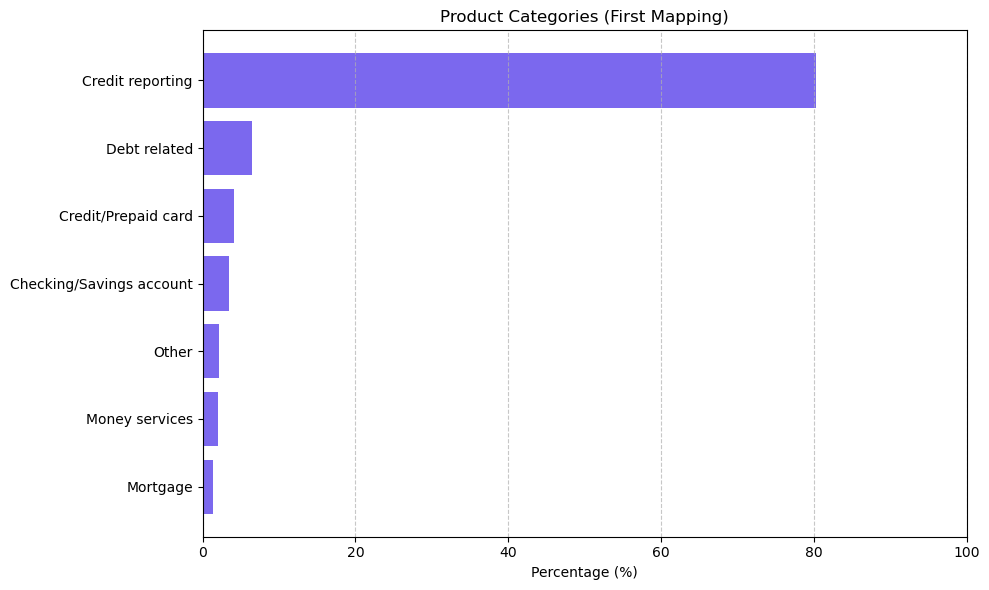

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_second_product_mapping.index.astype(str),
    summary_second_product_mapping['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Explore State Column

In [15]:
# summarize the state column
summary_state = summarize_categories(sample_df, column='state')
summary_state

,count,percentage
state,,
FL,53300,13.396302
TX,51771,13.012006
CA,39686,9.974590
GA,30413,7.643935
NY,24667,6.199748
IL,19365,4.867155
PA,17352,4.361213
NC,14088,3.540846
NJ,13270,3.335252


**Insights from Unique Values in the State Column**

Several data quality issues were identified in the `state` column, motivating normalization:

1. **Mixed formats:** Most values use US two-letter codes (e.g., NY, CA), but some use full names (e.g., "UNITED STATES MINOR OUTLYING ISLANDS").
2. **Missing values:** Some entries are NaN and require consistent handling.
3. **US territories:** Codes like PR (Puerto Rico), GU (Guam), VI (Virgin Islands), MP (Northern Mariana Islands), AS (American Samoa), and UM (Minor Outlying Islands) represent territories, not states.
4. **Military postal codes:** AE, AP, and AA indicate military addresses.
5. **Inconsistent representation:** Some locations appear in multiple formats (e.g., "UNITED STATES MINOR OUTLYING ISLANDS" vs "UM").
6. **Potential redundancy:** ZIP codes contain location info, but state normalization prevents mismatches.

---

**State Column Normalization Steps**

1. **Standardize format:** Uppercase all values and trim whitespace.
2. **Map full names to codes:** Convert names like "UNITED STATES MINOR OUTLYING ISLANDS" to "UM".
3. **Handle missing values:** Replace NaN with "Unknown".
4. **Classify state types:**
   - **State:** Standard US states and DC
   - **Territory:** PR, GU, VI, MP, AS, UM
   - **Military:** AE, AP, AA
   - **Unknown:** Missing/unrecognized entries
5. **Assign regions (US Census Bureau):**
   - **Northeast:** CT, ME, MA, NH, RI, VT, NJ, NY, PA
   - **Midwest:** IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD
   - **South:** DE, FL, GA, MD, NC, SC, VA, DC, WV, AL, KY, MS, TN, AR, LA, OK, TX
   - **West:** AZ, CO, ID, MT, NV, NM, UT, WY, AK, CA, HI, OR, WA
   - **Territory:** PR, GU, VI, MP, AS, UM
   - **Military:** AE, AP, AA
   - **Unknown:** Missing values

This normalization ensures the `state` column is consistent, analysis-ready, and suitable for grouping, visualization, and feature engineering.


### State Column Normalization

In [16]:
# State normalization mappings and groups
name_to_code = {'UNITED STATES MINOR OUTLYING ISLANDS': 'UM'}
territories = ['PR', 'GU', 'VI', 'MP', 'AS', 'UM']
military = ['AE', 'AP', 'AA']

# Define regions with their corresponding state codes
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest':   ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South':     ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West':      ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Normalize the state column
def normalize_state(val):
    if pd.isna(val): #  
        return 'Unknown'
    val = val.strip().upper()
    return name_to_code.get(val, val)

# Map state codes to groups
def map_group(code):
    if code == 'Unknown':
        return 'Unknown'
    if code in territories:
        return 'Territory'
    if code in military:
        return 'Military'
    return 'State'

# Map state codes to regions
def map_region(code):
    for region, codes in regions.items():
        if code in codes:
            return region
    if code in territories:
        return 'Territory'
    if code in military:
        return 'Military'
    if code == 'Unknown':
        return 'Unknown'
    return 'Other'

# Apply normalization and mapping functions to the 'state' column
sample_df['state_clean'] = sample_df['state'].apply(normalize_state)
sample_df['state_group'] = sample_df['state_clean'].apply(map_group)
sample_df['region'] = sample_df['state_clean'].apply(map_region)


,count,percentage
state_clean,,
FL,53300,13.356856
TX,51771,12.973692
CA,39686,9.945219
GA,30413,7.621427
NY,24667,6.181493
...,...,...
AP,28,0.007017
GU,15,0.003759
MP,4,0.001002


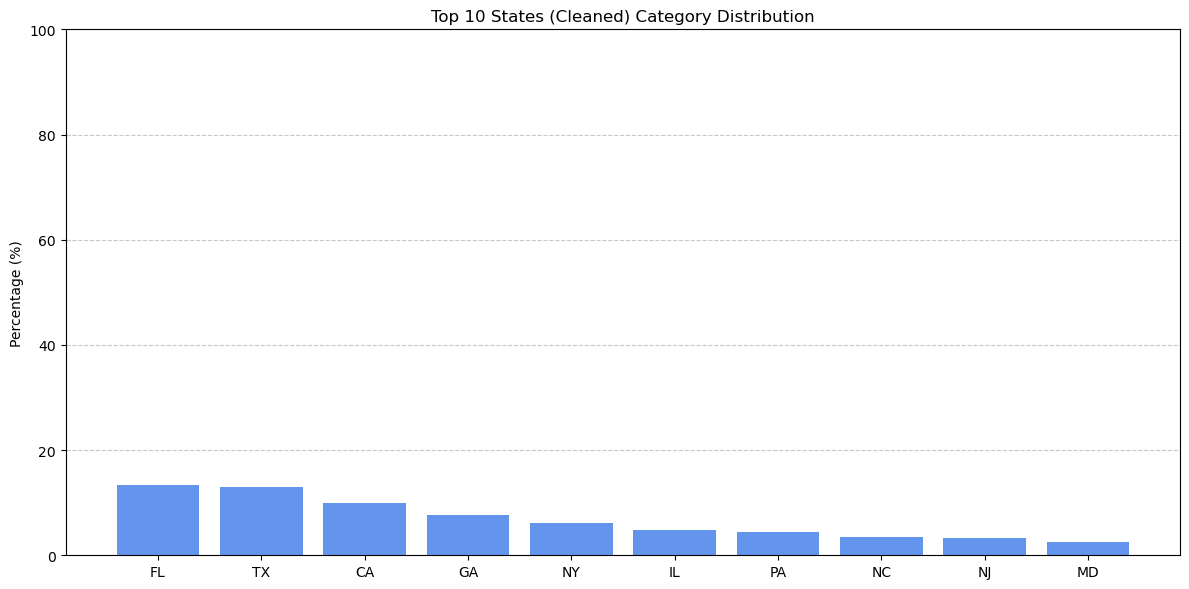

In [17]:
# Create summary for the cleaned state column
summary_state_clean = summarize_categories(sample_df, column='state_clean')
display(summary_state_clean)

# Visualize the summary
top10_state = summary_state_clean.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 States (Cleaned) Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

,count,percentage
state_group,,
State,396520,99.366990
Territory,1248,0.312746
Unknown,1175,0.294452
Military,103,0.025812


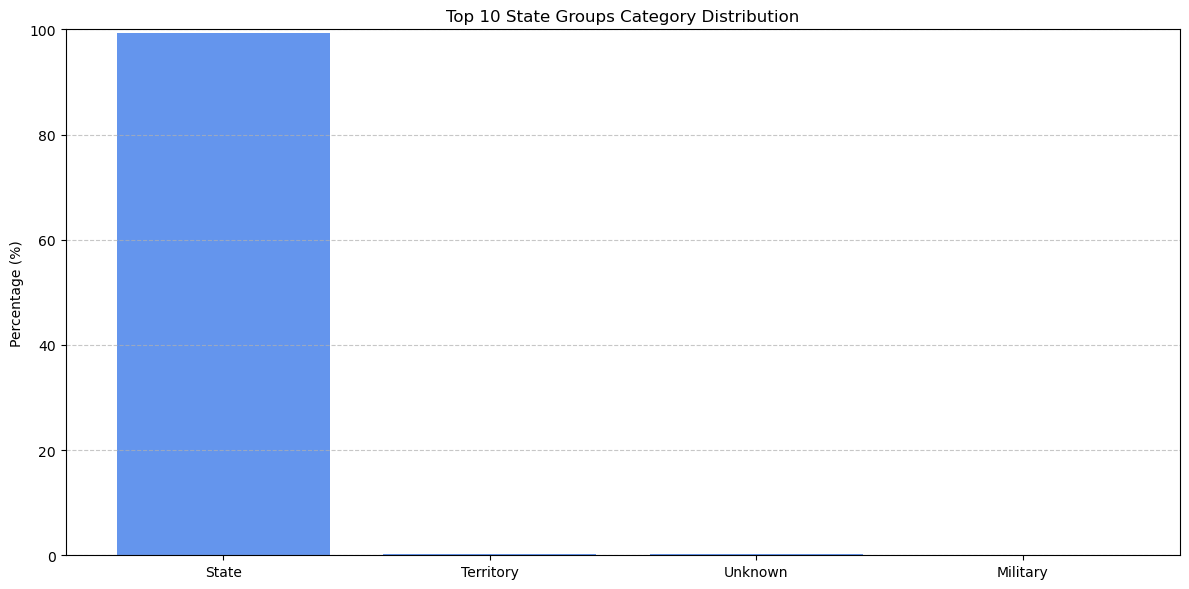

In [18]:
# Create summary for the cleaned state column
summary_state_group = summarize_categories(sample_df, column='state_group')
display(summary_state_group)

# Visualize the summary
top10_state = summary_state_group.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 State Groups Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

,count,percentage
region,,
South,212859,53.341971
Northeast,64801,16.238980
West,63071,15.805446
Midwest,55789,13.980594
Territory,1248,0.312746
Unknown,1175,0.294452
Military,103,0.025812


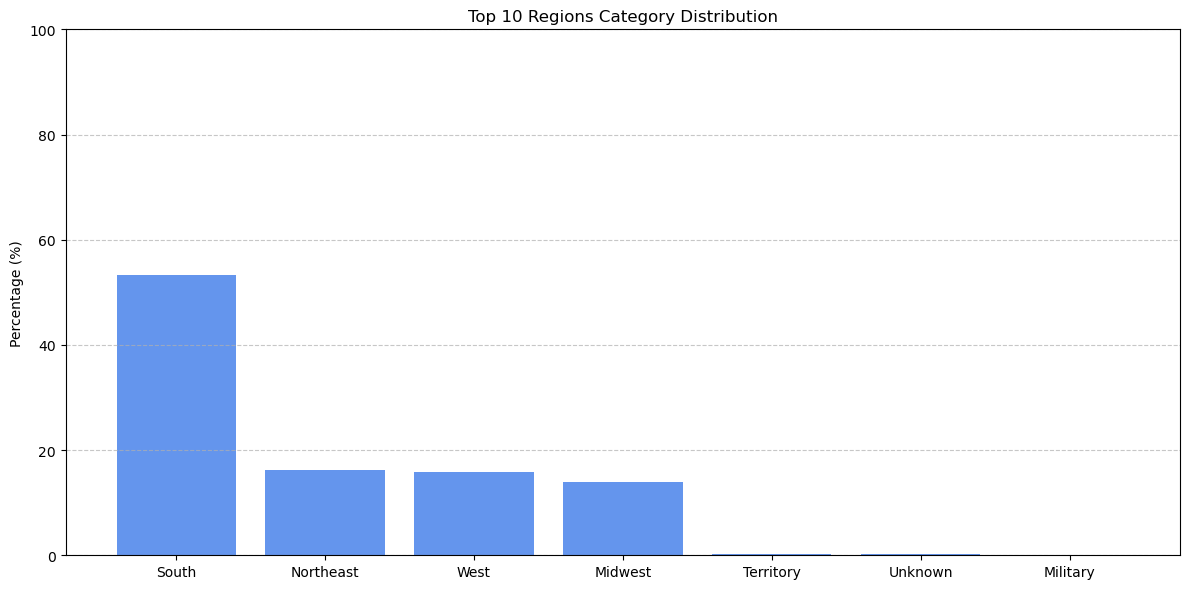

In [19]:
# Create summary for the cleaned state column
summary_region = summarize_categories(sample_df, column='region')
display(summary_region)

# Visualize the summary
top10_state = summary_region.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 Regions Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Time Analysis

### Distribution of Complaints by Year & Month

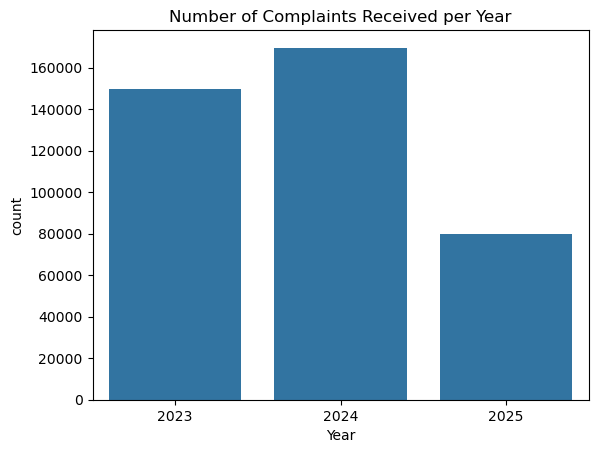

In [20]:
sns.countplot(x='date_received_year', data=sample_df)
plt.xlabel('Year')
plt.title('Number of Complaints Received per Year')
plt.show()

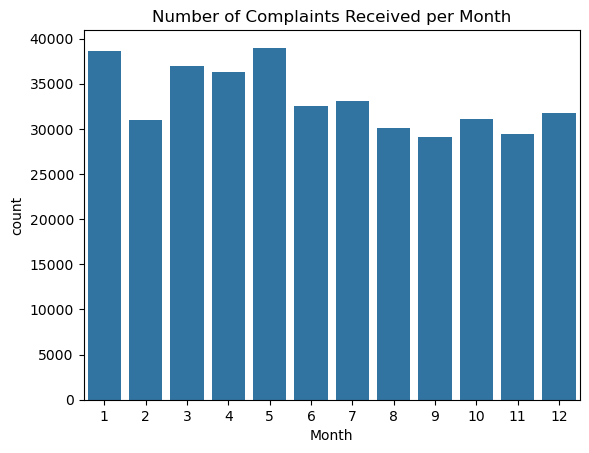

In [21]:
sns.countplot(x='date_received_month', data=sample_df)
plt.xlabel('Month')
plt.title('Number of Complaints Received per Month')
plt.show()

### Analysis of the time the complaint was received by the CFPB and the time the complaint was sent to the company

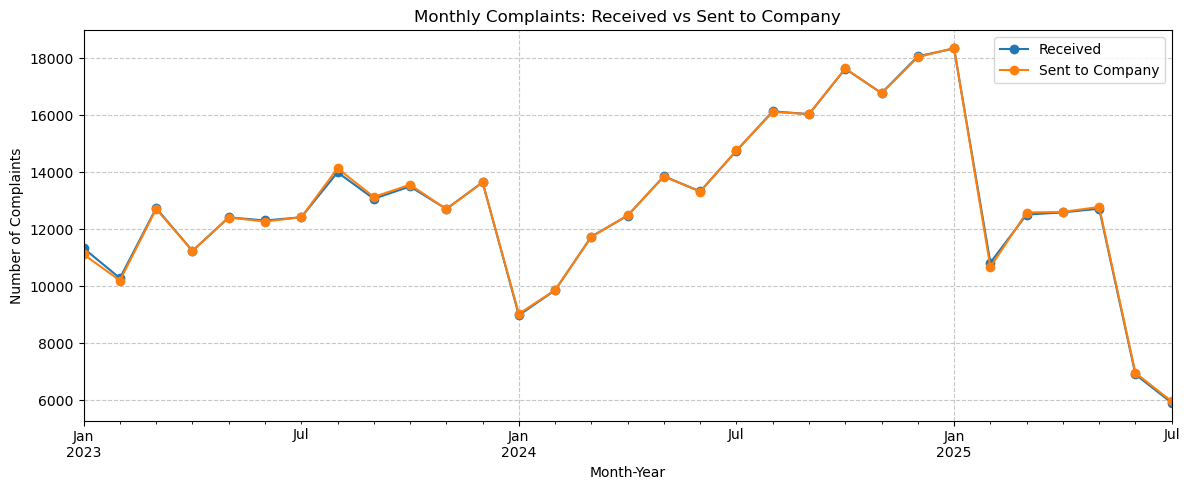

In [22]:
# Group by month and count the number of complaints received and sent to the company
monthly_received = sample_df.groupby(sample_df['date_received'].dt.to_period('M')).size()
monthly_sent = sample_df.groupby(sample_df['date_sent_to_company'].dt.to_period('M')).size()

# Create a DataFrame for monthly trends
monthly_trend = pd.DataFrame({
    'Received': monthly_received,
    'Sent to Company': monthly_sent
})

# plotting the monthly trend
plt.figure(figsize=(12, 5))
monthly_trend.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Complaints: Received vs Sent to Company')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

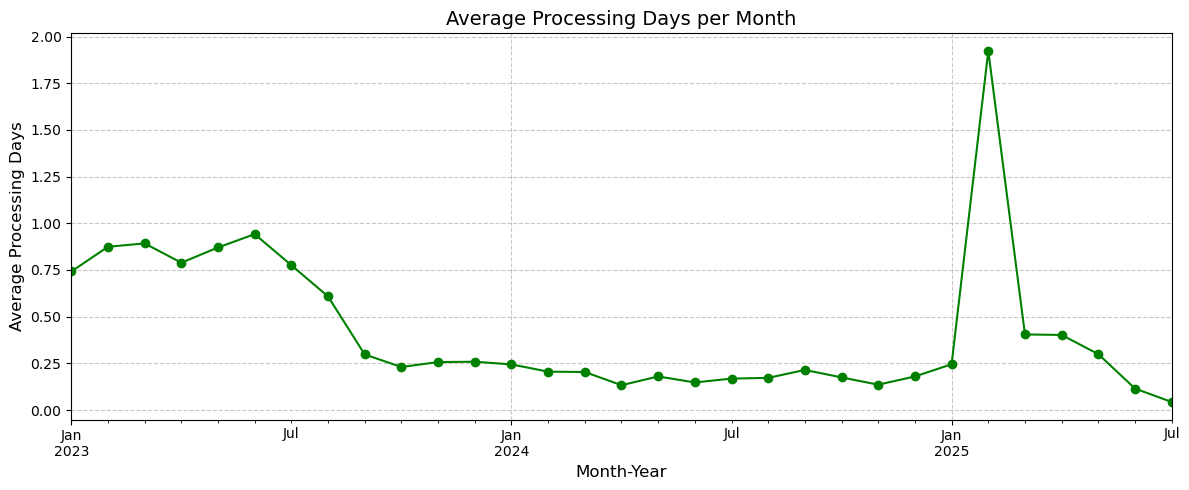

In [23]:
# Calculate the average processing days per month
avg_processing_days = sample_df.groupby(sample_df['date_received'].dt.to_period('M'))['processing_day'].mean()

# Plot the average processing days trend
plt.figure(figsize=(12, 5))
avg_processing_days.plot(marker='o', color='green')
plt.title('Average Processing Days per Month', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Processing Days', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

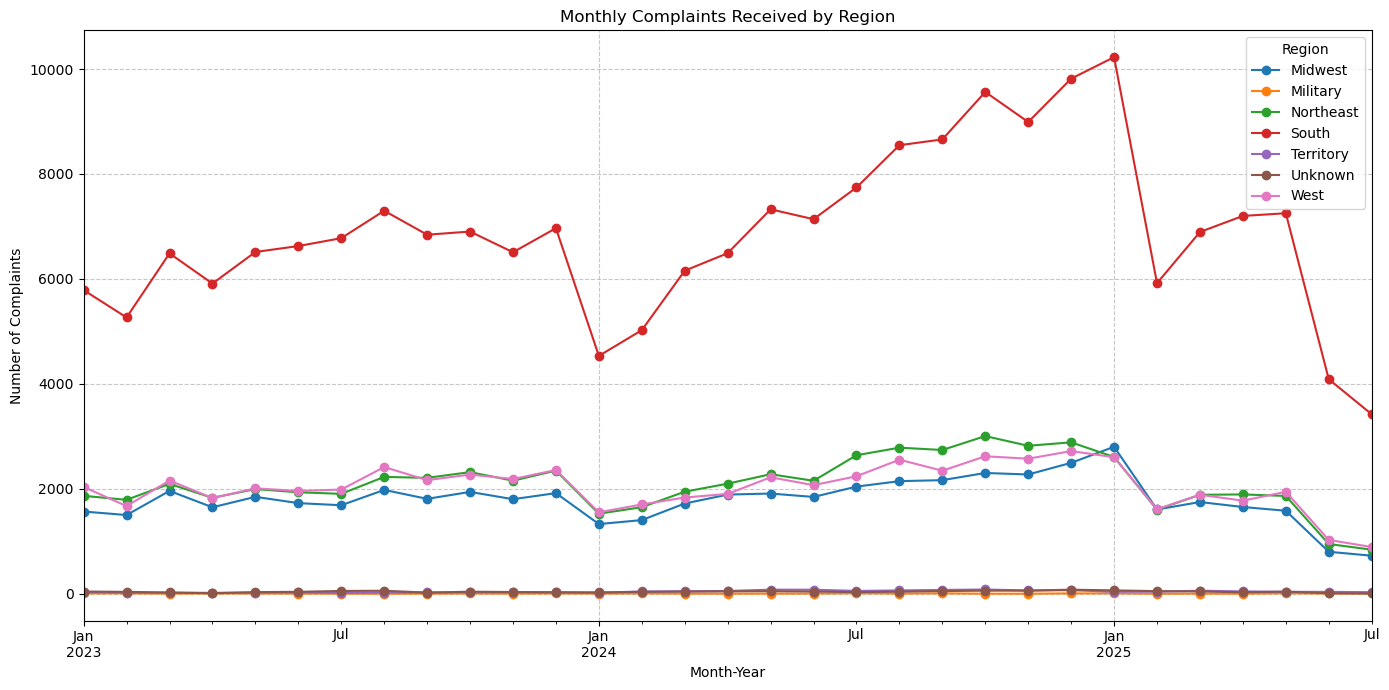

In [24]:
# Group by month-year and region, then visualize monthly complaints for each region
monthly_region = (
    sample_df
    .groupby([sample_df['date_received'].dt.to_period('M'), 'region'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14, 7))
monthly_region.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Complaints Received by Region')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.legend(title='Region')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Latent Dirichlet Allocation (LDA) Topic Modeling

## Data Preparation

**Prepare a Consumer Complaint Dataset** 

- leaving only the important columns (issue and consumer_complaint_narrative)
- removing empty data
- normalizing the text, and saving it in CSV format.

In [28]:
# Filter rows with non-null complaint narratives
consumer_complaints = sample_df[sample_df['consumer_complaint_narrative'].notnull()]

# Select only the relevant columns: issue and narrative
consumer_complaints = consumer_complaints[['issue', 'consumer_complaint_narrative']]

# Reset the index for a clean DataFrame
consumer_complaints = consumer_complaints.reset_index(drop=True)

# Normalize text: lowercase narratives
consumer_complaints['consumer_complaint_narrative'] = (
    consumer_complaints['consumer_complaint_narrative'].str.lower()
)

# Save raw filtered data before further cleaning
consumer_complaints.to_csv('./consumer_complaints_issues_n_narative.csv', index=False)

**Text Cleaning**

In [29]:
# Import dataset
consumer_complaints = pd.read_csv('./consumer_complaints_issues_n_narative.csv')

print("Step 1: Converting text to lowercase and removing extra spaces...")
consumer_complaints['consumer_complaint_narrative'] = (
    consumer_complaints['consumer_complaint_narrative']
    .progress_apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))
)

print("Step 2: Removing punctuation...")
consumer_complaints['consumer_complaint_narrative'] = (
    consumer_complaints['consumer_complaint_narrative']
    .progress_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
)

print("Step 3: Removing words containing the character 'x'...")
consumer_complaints['consumer_complaint_narrative'] = (
    consumer_complaints['consumer_complaint_narrative']
    .progress_apply(lambda x: " ".join(word for word in x.split() if "x" not in word))
)

print("Step 4: Removing numbers and words containing digits...")
consumer_complaints['consumer_complaint_narrative'] = (
    consumer_complaints['consumer_complaint_narrative']
    .progress_apply(lambda x: " ".join(word for word in x.split() if not any(c.isdigit() for c in word)))
)

# Extra Cleaning Step: Remove problematic rows
print("\nChecking for NaN, empty strings, or non-string values...")

before_rows = consumer_complaints.shape[0]

# Drop rows with NaN
consumer_complaints = consumer_complaints.dropna(subset=['consumer_complaint_narrative'])

# Drop rows with empty strings
consumer_complaints = consumer_complaints[consumer_complaints['consumer_complaint_narrative'].str.strip() != ""]

# Ensure column is string type
consumer_complaints['consumer_complaint_narrative'] = consumer_complaints['consumer_complaint_narrative'].astype(str)

after_rows = consumer_complaints.shape[0]
dropped_rows = before_rows - after_rows
print(f"Removed {dropped_rows} problematic rows. Remaining rows: {after_rows}")

# Save the cleaned DataFrame to a CSV file
output_path = "consumer_complaints_issues_n_narative_cleaned.csv"
consumer_complaints.to_csv(output_path, index=False)
print(f"Cleaning complete! Cleaned file saved to: {output_path}")

Step 1: Converting text to lowercase and removing extra spaces...


100%|██████████| 239524/239524 [00:19<00:00, 12331.87it/s]


Step 2: Removing punctuation...


100%|██████████| 239524/239524 [00:03<00:00, 77327.95it/s]


Step 3: Removing words containing the character 'x'...


100%|██████████| 239524/239524 [00:11<00:00, 21036.64it/s]


Step 4: Removing numbers and words containing digits...


100%|██████████| 239524/239524 [00:43<00:00, 5519.81it/s]



Checking for NaN, empty strings, or non-string values...
Removed 111 problematic rows. Remaining rows: 239413
Cleaning complete! Cleaned file saved to: consumer_complaints_issues_n_narative_cleaned.csv


In [30]:
# Load the cleaned dataset
consumer_complaints_cleaned = pd.read_csv("./consumer_complaints_issues_n_narative_cleaned.csv")

# Display info message + few rows=
print(f"Total Rows: {consumer_complaints_cleaned.shape[0]}, Total Columns: {consumer_complaints_cleaned.shape[1]}\n")
consumer_complaints_cleaned.head(10)

Total Rows: 239413, Total Columns: 2



,issue,consumer_complaint_narrative
0,Improper use of your report,is in violation of usc section a states i have...
1,Improper use of your report,address s does not belong to me inquiries do n...
2,Problem with a credit reporting company's inve...,the credit reporting agency is reporting infor...
3,Improper use of your report,is in violation of the that requires financial...
4,Incorrect information on your report,on i went to a walkin location and informed th...
5,Incorrect information on your report,the car dealership is located in off and this ...
6,Incorrect information on your report,first i want to thank you for helping me with ...
7,Improper use of your report,in accordance with the fair credit reporting a...
8,Improper use of your report,in accordance with the fair credit reporting a...
9,Improper use of your report,usc c a section states no consumer reporting a...


## Data Preprocessing

In [37]:
# Define stopwords and column
stop_words = set(stopwords.words("english"))
column = "consumer_complaint_narrative"

print("Removing Stopwords...")

# Function to remove stopwords safely
def remove_stopwords(text):
    if isinstance(text, str):  # Only process if text is string
        return " ".join(word for word in text.split() if word not in stop_words)
    return ""  # Replace NaN/float with empty string

# Apply function with progress bar
consumer_complaints_cleaned[column] = consumer_complaints_cleaned[column].progress_apply(remove_stopwords)

print("Stopwords removed successfully!\n\n")

consumer_complaints_cleaned.head(10)

Removing Stopwords...


100%|██████████| 239413/239413 [00:09<00:00, 24241.13it/s]

Stopwords removed successfully!




,issue,consumer_complaint_narrative
0,Improper use of your report,violation usc section states right section als...
1,Improper use of your report,address belong inquiries belong dispute
2,Problem with a credit reporting company's inve...,credit reporting agency reporting information ...
3,Improper use of your report,violation requires financial institutions comp...
4,Incorrect information on your report,went walkin location informed account equipmen...
5,Incorrect information on your report,car dealership located dealership old loan vol...
6,Incorrect information on your report,first want thank helping account opened going ...
7,Improper use of your report,accordance fair credit reporting act violated ...
8,Improper use of your report,accordance fair credit reporting act violated ...
9,Improper use of your report,usc c section states consumer reporting agency...


In [38]:
# Load spaCy model (disable unnecessary components for efficiency)
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Function to extract lemmatized text
def lemmatize_doc(doc):
    return " ".join([token.lemma_ for token in doc])

# Function to extract tokens
def tokenize_doc(doc):
    return [token.text for token in doc]

# Refactored: process texts with nlp.pipe (multicore)
def process_texts(texts, n_process=-1, batch_size=500):
    lemmatized = []
    tokenized = []

    # tqdm for progress bar
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts)):
        lemmatized.append(lemmatize_doc(doc))
        tokenized.append(tokenize_doc(doc))

    return lemmatized, tokenized


print("Starting Lemmatization + Tokenization (parallel)...")
consumer_complaints_cleaned["text_lemmatized"], consumer_complaints_cleaned["text_tokenized"] = process_texts(
    consumer_complaints_cleaned[column].fillna("").astype(str).tolist(),
    n_process=-1,  
    batch_size=2000  
)

print("Processing completed!")

# Quick check
print("Sample output:")
print(consumer_complaints_cleaned[["text_lemmatized", "text_tokenized"]].head())


Loading spaCy model...
Starting Lemmatization + Tokenization (parallel)...


100%|██████████| 239413/239413 [10:35<00:00, 376.44it/s]


Processing completed!
Sample output:
                                     text_lemmatized  \
0  violation usc section state right section also...   
1              address belong inquiry belong dispute   
2  credit reporting agency report information ina...   
3  violation require financial institution compan...   
4  go walkin location inform account equipment ch...   

                                      text_tokenized  
0  [violation, usc, section, states, right, secti...  
1      [address, belong, inquiries, belong, dispute]  
2  [credit, reporting, agency, reporting, informa...  
3  [violation, requires, financial, institutions,...  
4  [went, walkin, location, informed, account, eq...  


In [39]:
output_path = "consumer_complaints_lemmatized_tokenized.csv"
consumer_complaints_cleaned.to_csv(output_path, index=False)
print(f"Saved processed dataset to: {output_path}")

Saved processed dataset to: consumer_complaints_lemmatized_tokenized.csv


## Creating Document Term Matrix

In [40]:
def build_dictionary_and_corpus(texts):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

def plot_word_frequencies(dictionary, top_n=20):
    word_counts = dictionary.dfs 
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    words = [dictionary[w_id] for w_id, _ in sorted_counts]
    counts = [count for _, count in sorted_counts]

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Most Frequent Words")
    plt.show()

def plot_wordcloud(dictionary):
    word_freq = {dictionary[w_id]: freq for w_id, freq in dictionary.dfs.items()}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud from Dictionary")
    plt.show()

Sample BoW (document 0): [(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 1), (32, 2), (33, 2), (34, 1), (35, 1), (36, 1)]
Mapping BoW back to words: [('account', 2), ('agency', 1), ('already', 1), ('also', 3), ('appears', 1), ('bthere', 1), ('c', 1), ('consent', 1), ('consumer', 1), ('consumercredit', 1), ('credit', 1), ('deleted', 1), ('dispute', 1), ('disputenot', 1), ('furnish', 3), ('gave', 1), ('information', 2), ('instructions', 1), ('instructionsi', 1), ('like', 1), ('one', 1), ('prior', 1), ('report', 1), ('reporting', 1), ('reportwould', 1), ('right', 1), ('saying', 1), ('section', 2), ('states', 2), ('submitted', 1), ('system', 1), ('ths', 1), ('usc', 2), ('violation', 2), ('website', 1), ('without', 1), ('written', 1)]


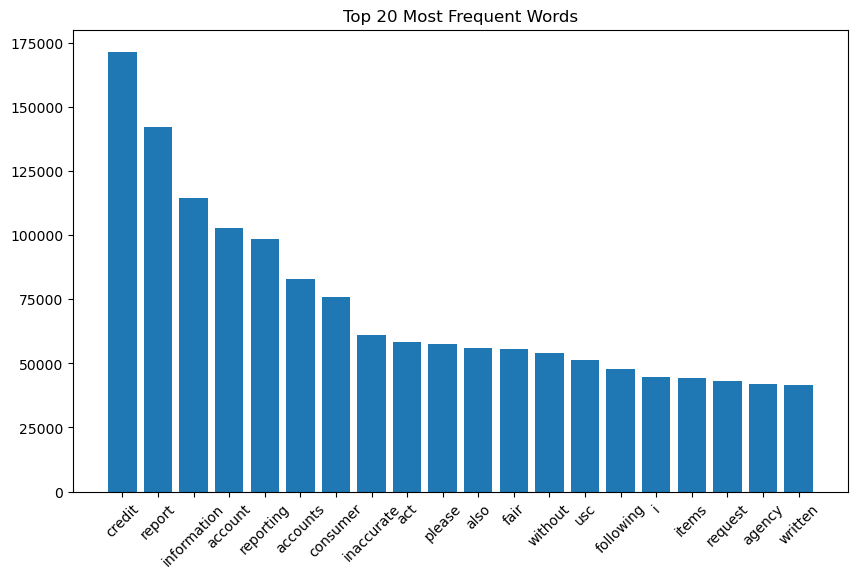

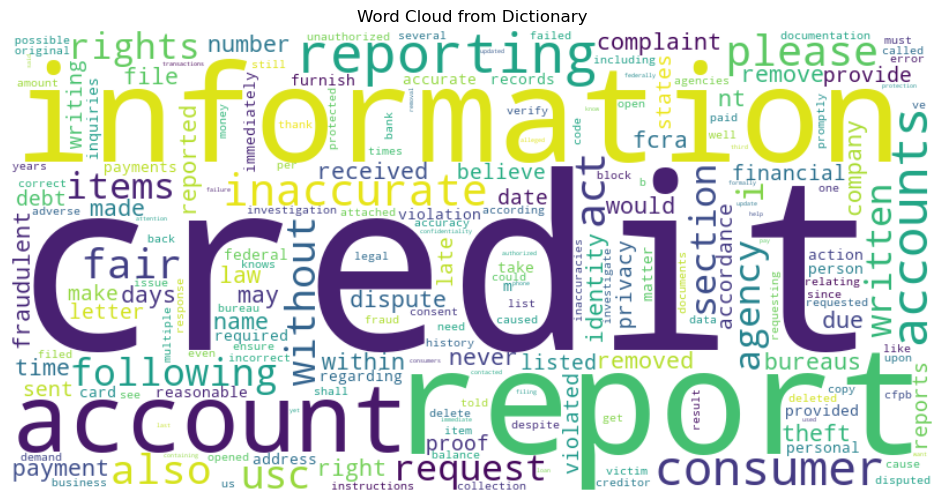

In [41]:
texts = consumer_complaints_cleaned["text_tokenized"].values

# Build dictionary & corpus
dictionary, corpus = build_dictionary_and_corpus(texts)

# Show a sample BoW representation
print("Sample BoW (document 0):", corpus[0])
print("Mapping BoW back to words:", [(dictionary[id], freq) for id, freq in corpus[0]])

# Visualizations
plot_word_frequencies(dictionary, top_n=20)
plot_wordcloud(dictionary)

## Latent Dirichlet Allocation (LDA)

In [42]:
# Define parameters
NUM_TOPICS = 10
RANDOM_STATE = 10
CHUNKSIZE = 100
PASSES = 10
WORKERS = 10

print("Training LDA Multicore Model...")
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=RANDOM_STATE,
    chunksize=CHUNKSIZE,
    passes=PASSES,
    per_word_topics=True,
    workers=WORKERS
)
print("LDA Training Completed!")

# Print summary of topics
print("\nSample Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Training LDA Multicore Model...
LDA Training Completed!

Sample Topics:
Topic 0: 0.049*"credit" + 0.025*"report" + 0.021*"reporting" + 0.020*"information" + 0.019*"fcra" + 0.014*"request" + 0.014*"accounts" + 0.012*"inaccurate" + 0.012*"act" + 0.011*"fair"
Topic 1: 0.050*"i" + 0.049*"credit" + 0.036*"report" + 0.027*"information" + 0.025*"complaint" + 0.022*"bureaus" + 0.022*"m" + 0.021*"accounts" + 0.021*"ve" + 0.020*"letters"
Topic 2: 0.049*"debt" + 0.015*"collection" + 0.012*"proof" + 0.012*"act" + 0.012*"practices" + 0.010*"financial" + 0.009*"alleged" + 0.008*"validation" + 0.008*"provide" + 0.008*"fdcpa"
Topic 3: 0.082*"payment" + 0.074*"late" + 0.044*"payments" + 0.028*"credit" + 0.017*"account" + 0.017*"error" + 0.016*"due" + 0.015*"days" + 0.015*"never" + 0.014*"accounts"
Topic 4: 0.086*"account" + 0.070*"credit" + 0.045*"report" + 0.027*"date" + 0.024*"information" + 0.019*"number" + 0.018*"please" + 0.018*"reporting" + 0.017*"accounts" + 0.016*"name"
Topic 5: 0.062*"inquirie

In [43]:
# Save the model
MODEL_PATH = "lda_model.gensim"
lda_model.save(MODEL_PATH)
print(f"LDA Model saved to {MODEL_PATH}")

LDA Model saved to lda_model.gensim


In [48]:
# Get topics
lda_topics = lda_model.print_topics(num_topics=-1)

# Create DataFrame
topics_df = pd.DataFrame(lda_topics, columns=['Topic_ID', 'Top_Words'])

# Remove weights/digits from top words
def clean_top_words(top_words_str):
    # Remove all numbers, asterisks, and quotes
    clean_str = re.sub(r'\d+\.\d+\*"', '', top_words_str)
    clean_str = clean_str.replace('"', '')  # remove remaining quotes
    clean_str = clean_str.replace('+', ',')  # replace + with comma for readability
    return clean_str.strip()

topics_df['Top_Words'] = topics_df['Top_Words'].apply(clean_top_words)

# Add Topic Phrase & Description
topic_phrases = [
    "Credit Report Issues",
    "Personal Credit Complaints",
    "Debt Collection Disputes",
    "Late Payments & Credit Errors",
    "Account Reporting Issues",
    "Credit Inquiries & Fraud",
    "Banking & Loan Concerns",
    "Legal / Regulatory Information",
    "Consumer Law Violations",
    "Identity Theft"
]

topic_descriptions = [
    "Concerns about credit reports, FCRA compliance, and inaccurate account information.",
    "Consumers discussing their own credit reports and filing complaints with bureaus.",
    "Issues related to debt collection, validation of debts, and financial disputes.",
    "Problems regarding late payments, credit errors, and account management.",
    "Topics related to credit accounts, reporting dates, and account details.",
    "Unauthorized credit inquiries, potential fraud, and consumer reporting issues.",
    "Consumer discussions on bank accounts, loans, cards, and money transactions.",
    "Topics involving consumer rights, US Code sections, reporting obligations, and agencies.",
    "Discussions on violations of consumer protection laws, reporting, and credit issues.",
    "Topics related to identity theft, fraud, and protective actions for consumers."
]

topics_df['Topic_Phrase'] = topic_phrases
topics_df['Description'] = topic_descriptions

# Reorder columns
topics_df = topics_df[['Topic_ID', 'Topic_Phrase', 'Description', 'Top_Words']]

topics_df.to_csv('lda_topics.csv', index=False)

# Display
topics_df

,Topic_ID,Topic_Phrase,Description,Top_Words
0,0,Credit Report Issues,"Concerns about credit reports, FCRA compliance...","credit , report , reporting , information , fc..."
1,1,Personal Credit Complaints,Consumers discussing their own credit reports ...,"i , credit , report , information , complaint ..."
2,2,Debt Collection Disputes,"Issues related to debt collection, validation ...","debt , collection , proof , act , practices , ..."
3,3,Late Payments & Credit Errors,"Problems regarding late payments, credit error...","payment , late , payments , credit , account ,..."
4,4,Account Reporting Issues,"Topics related to credit accounts, reporting d...","account , credit , report , date , information..."
5,5,Credit Inquiries & Fraud,"Unauthorized credit inquiries, potential fraud...","inquiries , credit , inquiry , report , consum..."
6,6,Banking & Loan Concerns,"Consumer discussions on bank accounts, loans, ...","account , bank , would , nt , card , loan , re..."
7,7,Legal / Regulatory Information,"Topics involving consumer rights, US Code sect...","consumer , usc , section , reporting , informa..."
8,8,Consumer Law Violations,Discussions on violations of consumer protecti...,"consumer , information , reporting , code , us..."
9,9,Identity Theft,"Topics related to identity theft, fraud, and p...","identity , theft , report , credit , informati..."


## LDA Evaluation

In [44]:
print("\nEvaluating LDA Model...")

# Perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Model Perplexity: {perplexity:.4f}")

# Coherence Score (using c_v measure, populer untuk interpretasi topik)
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=consumer_complaints_cleaned["text_tokenized"].values,   # tokenized text hasil preprocessing
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model_lda.get_coherence()
print(f"Model Coherence Score: {coherence_score:.4f}")

print("\nEvaluation Completed!")


Evaluating LDA Model...
Model Perplexity: -6.7237
Model Coherence Score: 0.5622

Evaluation Completed!


## LDA Visualization

In [49]:
# Create LDA visualization
lda_vis = pyLDAvis.gensim_models.prepare(
    lda_model, corpus, dictionary, sort_topics=False
)

pyLDAvis.display(lda_vis)

## LDA Hyperparameter Tuning

In [50]:
def Train_LDA_Compute_Coherence(
    corpus, dictionary, data_lemmatized, 
    num_of_topics, alpha, beta, num_of_paases, 
    workers=4, coherence='c_v'
):
    # Train the LDA model using multicore processing for faster computation
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_of_topics,
        random_state=10,      # for reproducibility
        chunksize=100,        # number of documents to be used in each training chunk
        passes=num_of_paases, # number of passes through the corpus
        alpha=alpha,          # document-topic density
        eta=beta,             # word-topic density
        workers=workers       # number of CPU cores used
    )

    # Build a coherence model to evaluate the quality of the topics
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=data_lemmatized,
        dictionary=dictionary,
        coherence=coherence
    )

    # Return the coherence score (higher = better topic quality)
    return coherence_model_lda.get_coherence()


**Create Grid of Hyperparameters**

In [75]:
# Topics range
min_topics = 2
max_topics = 5
step_size = 1
topics_range = [5,25,50,100,150] # range(min_topics, max_topics, step_size)

# Alpha parameter
alpha_options = list(np.arange(0.01, 1, 0.475))
alpha_options.append('symmetric')
alpha_options.append('asymmetric')

# Beta parameter
beta_options = list(np.arange(0.01, 1, 0.475))
beta_options.append('symmetric')

tuning_results = pd.DataFrame(columns=['Number of Topics', 'Alpha', 'Beta'])

# Create Array of possible combination of above parameters
hyperparameters = np.array( np.meshgrid(alpha_options, beta_options, topics_range)).T.reshape(-1, 3)
tuning_results['Alpha']= hyperparameters[:,0]
tuning_results['Beta']= hyperparameters[:,1]
tuning_results['Number of Topics']= hyperparameters[:,2]
tuning_results

,Number of Topics,Alpha,Beta
0,5,0.01,0.01
1,5,0.01,0.485
2,5,0.01,0.96
3,5,0.01,symmetric
4,5,0.485,0.01
...,...,...,...
95,150,symmetric,symmetric
96,150,asymmetric,0.01
97,150,asymmetric,0.485
98,150,asymmetric,0.96


**Tunning Process**

In [76]:
stages_of_passes = [2, 5, 10]  # different numbers of passes (epochs) to test
num_of_tops_hyperparameter = [5, 3]  # number of top hyperparameter sets to keep at each stage
num_of_tops_hyperparameter.append(num_of_tops_hyperparameter[-1])  # extend list so it matches stages
tuning_df = tuning_results.copy()  # make a copy of initial hyperparameter grid

# Loop through each stage (number of passes)
for stage in range(0, len(stages_of_passes)):
    print(f"\n=== Stage {stage+1}/{len(stages_of_passes)}: passes = {stages_of_passes[stage]} ===")
    scores = []  # store coherence scores for this stage

    # Iterate through each hyperparameter configuration in tuning_results
    for i in tqdm(range(0, tuning_results.shape[0]), desc=f"Processing hyperparameters for stage {stage}"):
        hyperparameter = tuning_results.iloc[i]

        # Try to convert Alpha to float, otherwise keep as string (e.g., 'symmetric', 'asymmetric')
        try:
            Alpha = float(hyperparameter['Alpha'])
        except:
            Alpha = hyperparameter['Alpha']

        # Try to convert Beta (eta) to float, otherwise keep as string
        try:
            Beta = float(hyperparameter['Beta'])
        except:
            Beta = hyperparameter['Beta']
        
        # Try to convert Number of Topics to int
        try:
            Number_of_Topics = int(hyperparameter['Number of Topics'])
        except:
            Number_of_Topics = hyperparameter['Number of Topics']

        # Train LDA model and compute coherence score for this configuration
        print(f"Training LDA with Topics={Number_of_Topics}, Alpha={Alpha}, Beta={Beta}...")
        score = Train_LDA_Compute_Coherence(
            corpus=corpus, 
            dictionary=dictionary, 
            data_lemmatized=consumer_complaints_cleaned["text_lemmatized"].values, 
            num_of_topics=Number_of_Topics, 
            alpha=Alpha, 
            beta=Beta, 
            num_of_paases=stages_of_passes[stage],  # passes depend on stage
            workers=10
        )
        print(f"Coherence score: {score:.4f}")
        scores.append(score)  # store result

    # Add coherence scores for this stage to tuning_df
    tuning_df["coherence score stage " + str(stage)] = scores

    # Sort by coherence score (descending) to find best configurations
    tuning_df = tuning_df.sort_values(by="coherence score stage " + str(stage), ascending=False)

    # Keep only the top-N hyperparameter sets for the next stage
    tuning_df = tuning_df.head(num_of_tops_hyperparameter[stage])
    print(f"Top {num_of_tops_hyperparameter[stage]} hyperparameter sets selected for next stage.")

# Save the final hyperparameter tuning results to CSV
output_path = "lda_hyperparameter_tuning_results.csv"
tuning_df.to_csv(output_path, index=False)
print(f"\n✅ Hyperparameter tuning results saved to: {output_path}")

# Final DataFrame with best hyperparameter sets across stages
print("\nFinal top hyperparameter sets:")
print(tuning_df)


  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 